# 1. Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import xgboost as xb
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

# set random seed to 1 for predictable results
np.random.seed(1)

# 2. Load & Scale the data

In [2]:
data = pd.read_csv('concrete.csv')

data_scaler = StandardScaler()
data_scaler.fit(data)
scaled_data = data_scaler.transform(data)  
data = pd.DataFrame(data=scaled_data, columns=data.columns)

X = data[['cement','slag','ash','water','superplastic','coarseagg','fineagg','age']]
y = data['strength']

# 3. Split into training & testing data

In [3]:
trainX, testX, trainY, testY = train_test_split(X,y)

dTrainMatrix = xb.DMatrix(trainX, trainY)
dTextMatrix = xb.DMatrix(testX, testY)

C:\MachineLearning\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# Note about experiments:

    I have tried using XGBoost and RandomForest to work on this problem. In terms of different runs, a summary is as follows:
    
    Run 1 -> Baseline model using XGBoost without any model tuning
    Run 2 -> Refined model using XGBoost with Hyperparameter tuning using GridSearchCV
    
    For each of these runs I have looked at most important features
    
    Run 3 -> Baseline model using RandomForest without any model tuning
    Run 4 -> Refine model using RandomForest with Hyperparameter tuning using GridSearchCV
    
    Summary:
    -------------------------------------------
    XGBoost      (Without Tuning)  : MSE of 0.1050
    XGBoost      (With Tuning)     : MSE of 0.0815
    RandomForest (Without Tuning)  : MSE of 0.1127
    RandomForest (With Tuning)     : MSE of 0.1148

# Run 1 - Baseline model using XGBoost without any model tuning

In [4]:
xgboost_baseline_model = XGBRegressor()
xgboost_baseline_model.fit(trainX, trainY)
predictedY = xgboost_baseline_model.predict(testX)

mse = mean_squared_error(testY, predictedY)
print ('MSE for baseline model is :',mse)

print ('\n',xgboost_baseline_model)

MSE for baseline model is : 0.10508835025344296

 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)


# Run 2 - Hyper Parameter tuning with GridSearchCV
    
    - GridSearchCV is like a brute force attack where all possible combinations of hyper parameters are evaluared.
    - Logic wise it works as follows:
        - Create a dictionary of fixed params; those params which would not change during the tuning exercise
        - Create a dictionary of variable params; those params which we want to evaluate
        - Create GridSearchCV() and pass in the following:
            - XGBClassifier or XGBRegressor ; in this we pass the fixed params
            - variable params
            - cv or cross validation count
            - scoring (scoring approach depends on Regression or Classification problem)
            
     - On this datasetp trying to tune the hyper parameters does not reduce MAE any further, instead it's increased !!!
     - Useful link
         - See https://scikit-learn.org/stable/modules/model_evaluation.html for scoring options

In [5]:
#from sklearn.metrics import SCORERS
#sorted(SCORERS.keys())

In [6]:
fixed_params = {"objective":"reg:linear"}
variable_params = {
    "max_depth":np.arange(1,10,2),
    "learning_rate":np.arange(0.1,0.6,0.1),
    "n_estimators":np.arange(10,100,20),
    "reg_alpha":np.arange(0.0,0.6,0.2),
    "n_fold":np.arange(2,10,2)
}

gs_cv_xg = GridSearchCV(XGBRegressor(**fixed_params), variable_params, cv=3, scoring='neg_mean_squared_error', n_jobs=3)
gs_cv_xg.fit(trainX, trainY)

C:\MachineLearning\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=1,
                                    nthread=None, objective='reg:linear',
                                    random_state=0, reg_alpha=0, reg_lam...
                                    scale_pos_weight=1, seed=None, silent=True,
                                    subsample=1),
             iid='warn', n_jobs=3,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'max_depth': array([1, 3, 5, 7, 9]),
                         'n_estimators': array([10, 30, 50,

#### Print the best found parameters, best score and best model definition

In [7]:
print ('Best parameters are ', gs_cv_xg.best_params_)
print ('Best MSE score is ', np.abs(gs_cv_xg.best_score_))

#print ('Evaluated params grid is \n', gs_cv_xg.param_grid)
#print ('\n\nBest model definition is \n', gs_cv_xg.best_estimator_)

Best parameters are  {'learning_rate': 0.30000000000000004, 'max_depth': 5, 'n_estimators': 90, 'n_fold': 2, 'reg_alpha': 0.4}
Best MSE score is  0.08034740276547615


In [8]:
final_model = XGBRegressor(learning_rate=0.30000000000000004,
                          max_depth=5,
                          n_estimators=90,
                          reg_alpha=0.4)

final_model.fit(trainX, trainY)
predictedY = final_model.predict(testX)

mse = mean_squared_error(testY, predictedY)
print ('MSE for tuned xgboost model is :',mse)

MSE for tuned xgboost model is : 0.08157796576749049


### XGBoost Model - Feature Importance

    - We see that 'age', 'cement' and 'superplastic' are the top three most important features

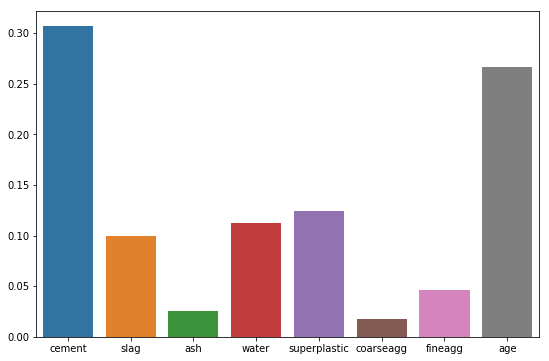

In [9]:
feature_imp = final_model.feature_importances_
plt.figure(figsize=(9,6))
sb.barplot(X.columns, feature_imp, orient='v')

# Run 4 -> Baseline model using RandomForest without any model tuning

In [10]:
from sklearn.ensemble import RandomForestRegressor

baseline_rf = RandomForestRegressor()
baseline_rf.fit(trainX, trainY)
predictedY = baseline_rf.predict(testX)

print ('MSE of baseline RandomForest model is :',mean_squared_error(testY, predictedY))

MSE of baseline RandomForest model is : 0.11278317888639833


C:\MachineLearning\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
baseline_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

# Run 5 -> Refine model using RandomForest with Hyperparameter tuning using GridSearchCV

In [12]:
variable_params = {
    "max_depth":np.arange(1,10,2),
    "n_estimators":np.arange(10,50,10)
}

rf_gs_cv = GridSearchCV(RandomForestRegressor(), variable_params, cv=3, scoring='neg_mean_squared_error', n_jobs=3)
rf_gs_cv.fit(trainX, trainY)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=3,
             param_grid={'max_depth': array([1, 3, 5, 7, 9]

In [13]:
print ('Best parameters are ', rf_gs_cv.best_params_)
print ('Best MSE score is ', np.abs(rf_gs_cv.best_score_))

#print ('Evaluated params grid is \n', rf_gs_cv.param_grid)
#print ('\n\nBest model definition is \n', rf_gs_cv.best_estimator_)

Best parameters are  {'max_depth': 9, 'n_estimators': 40}
Best MSE score is  0.10897221845843871


In [14]:
final_rf = RandomForestRegressor(max_depth=9,n_estimators=20)
final_rf.fit(trainX, trainY)
predictedY_rf = final_rf.predict(testX)

print ('MSE of tuned RandomForest model is :',mean_squared_error(testY, predictedY_rf))

MSE of tuned RandomForest model is : 0.11484917310154936


### RandomForest Model - Feature Importance
    - We see that 'age', 'cement' and 'superplastic' are the top three most important features

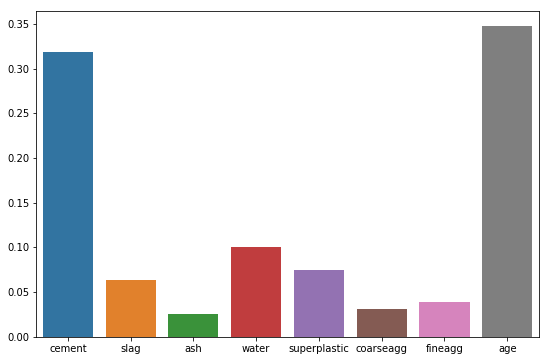

In [15]:
feature_imp_rf = final_rf.feature_importances_
plt.figure(figsize=(9,6))
sb.barplot(X.columns, feature_imp_rf, orient='v')